<img src="https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/AT%26T_logo_2016.svg" alt="AT&T LOGO" width="50%" />

# Orange SPAM detector

## Company's Description 📇

AT&T Inc. is an American multinational telecommunications holding company headquartered at Whitacre Tower in Downtown Dallas, Texas. It is the world's largest telecommunications company by revenue and the third largest provider of mobile telephone services in the U.S. As of 2022, AT&T was ranked 13th on the Fortune 500 rankings of the largest United States corporations, with revenues of $168.8 billion! 😮

## Project 🚧

One of the main pain point that AT&T users are facing is constant exposure to SPAM messages.

AT&T has been able to manually flag spam messages for a time, but they are looking for an automated way of detecting spams to protect their users.

## Goals 🎯

Your goal is to build a spam detector, that can automatically flag spams as they come based solely on the sms' content.

## Scope of this project 🖼️

To start off, AT&T would like you to use the folowing dataset:

[Dowload the Dataset](https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv)

## Helpers 🦮

To help you achieve this project, here are a few tips that should help you: 

### Start simple
A good deep learing model does not necessarily have to be super complicated!

### Transfer learning
You do not have access to a whole lot of data, perhaps channeling the power of a more sophisticated model trained on billions of observations might help!

## Deliverable 📬

To complete this project, your team should: 

* Write a notebook that runs preprocessing and trains one or more deep learning models in order to predict the spam or ham nature of the sms
* State the achieved performance clearly

---
## LIBRAIRIES
---

In [42]:
# librairies usuelles
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

# librairies qui vont servir lors du preprocessing textuel
import datetime
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import re

# librairies pour nos modèles : Tensorflow et Transformers de Hugging Face (pour les modèles pré-entraînés)
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, GRU, LSTM, GlobalAveragePooling1D, Conv1D


# classes et méthodes de Scikit-Learn pour le préprocessing, le splitting, les métriques, etc...
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss



---
## PREMIERES APPROCHES
---

In [43]:
# import
url = "https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv"
df = pd.read_csv(url, encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [44]:
df.shape

(5572, 5)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [46]:
# vérif du type de contenu des colonnes Unnamed
df['Unnamed: 2'].dropna().head(10)


95                                            PO Box 5249
281      the person is definitely special for u..... B...
444      HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...
671      wanted to say hi. HI!!!\" Stop? Send STOP to ...
710       this wont even start........ Datz confidence.."
899                                           PO Box 5249
1038                                                   GN
1127                                             .;-):-D"
1266    just been in bedbut mite go 2 thepub l8tr if u...
1384     bt not his girlfrnd... G o o d n i g h t . . .@"
Name: Unnamed: 2, dtype: object

La majeur partie du texte de l'email se trouve dans la colonne V2 mais il peut y avoir des restes dans les colonnes "Unnamed". Fusionnons l'ensemble et supprimons ces colonnes devenues inutiles.

In [47]:
# Fusion sans introduire d'espaces inutiles
df['v2'] = df['v2'].str.cat(
    [df['Unnamed: 2'].fillna(''), 
     df['Unnamed: 3'].fillna(''), 
     df['Unnamed: 4'].fillna('')], 
    sep=' '
).str.strip()

.str.cat() :a daptée pour concaténer plusieurs colonnes, car elle permet d'ajouter un séparateur (sep=' ') entre les colonnes.
.str.strip() : Supprime les espaces en début et fin de la chaîne résultante.

In [48]:
# Nettoyage des colonnes redondantes
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

Même si nous avons fait attention de bien fusionner les colonnes sans créer d'espace, il pourrait y avoir quelques doubles espaces. Sur ma Baseline il y aura un préprocessing sur des éléments de mises en forme. Mais lorsque nous testerons BERT, cela ne sera pas le cas.

In [49]:
# Compter le nombre de doubles espaces
nb_double_spaces = df['v2'].str.count('  ').sum()
print(f"Nombre de doubles espaces trouvés : {nb_double_spaces}")

Nombre de doubles espaces trouvés : 480


In [50]:
# Nettoyage des espaces multiples
df['v2'] = df['v2'].str.replace(r'\s+', ' ')  # Remplace tous les espaces multiples par un seul espace

In [51]:
# renommage des colonnes
df = df.rename(columns={'v1': 'target', 'v2': 'text'})

---
### EDA
---

In [52]:
# vérifier les valeurs de la colonne target
df['target'].value_counts()

target
ham     4825
spam     747
Name: count, dtype: int64

In [53]:
#schéma de la distribution des valeurs de la colonne target
fig = px.pie(df, names='target', title='Distribution des valeurs de la colonne target')
fig.show()

In [54]:
#graphique de la longueur des messages par rapport à la target
df['length'] = df['text'].apply(len)
fig = px.histogram(df, x='length', color='target', title='Longueur des messages par rapport à la target')
fig.show()

- Les messages "ham" sont généralement plus courts.
- Une forte concentration de messages courts
- Les messages "spam" ont tendance à être plus longs, avec un pic vers entre 150 et 200

Il serait intéressant de regarder un peu le contenu des messages spam vs les message non spam. Quels sont les mots redondants dans les spam, est-ce qu'il y a des url pour le fishing ou des numéros de téléphones ?

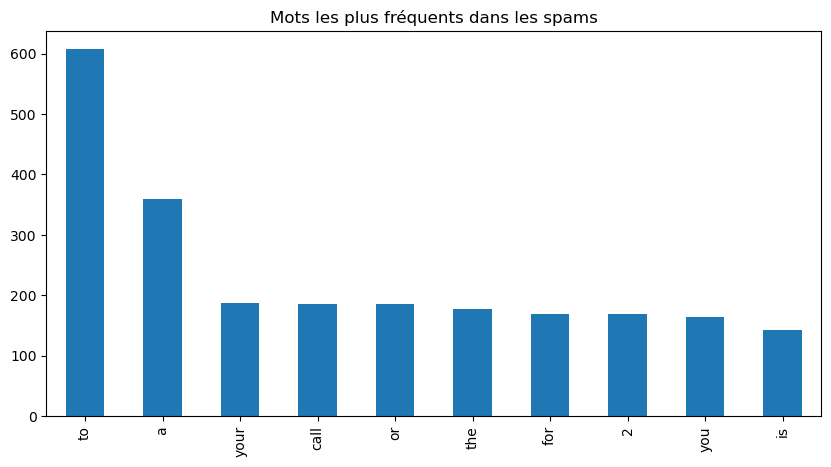

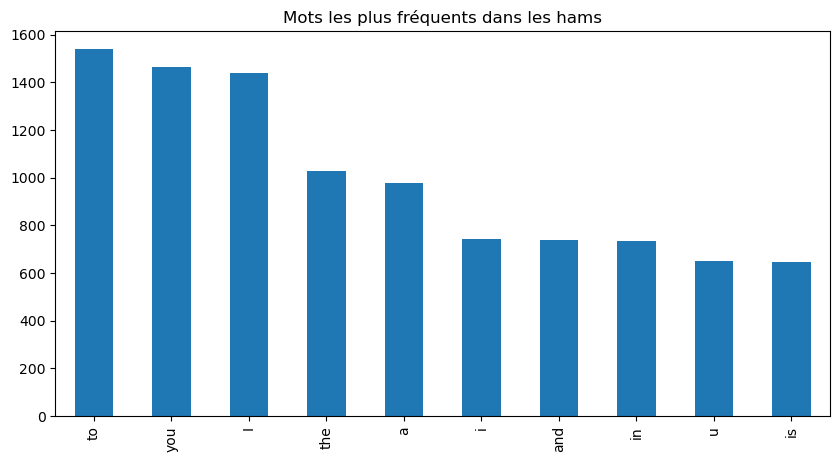

In [55]:
# Pour les spams
spam_text = ' '.join(df[df['target']=='spam']['text']).split()
spam_freq = pd.Series(spam_text).value_counts().head(10)

plt.figure(figsize=(10,5))
spam_freq.plot(kind='bar')
plt.title('Mots les plus fréquents dans les spams')
plt.show()

# Pour les hams 
ham_text = ' '.join(df[df['target']=='ham']['text']).split()
ham_freq = pd.Series(ham_text).value_counts().head(10)

plt.figure(figsize=(10,5))
ham_freq.plot(kind='bar')
plt.title('Mots les plus fréquents dans les hams')
plt.show()

Pas très parlant !

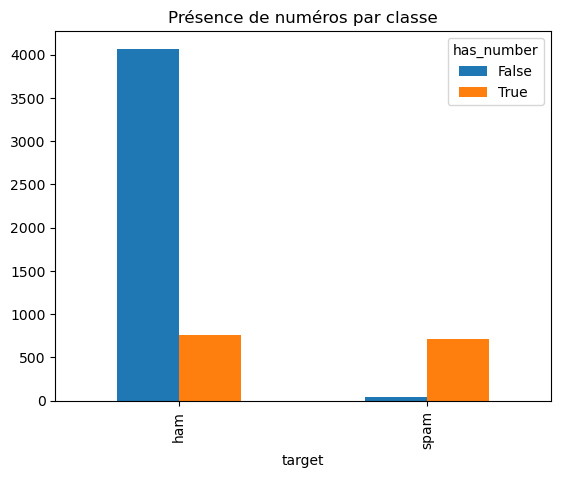

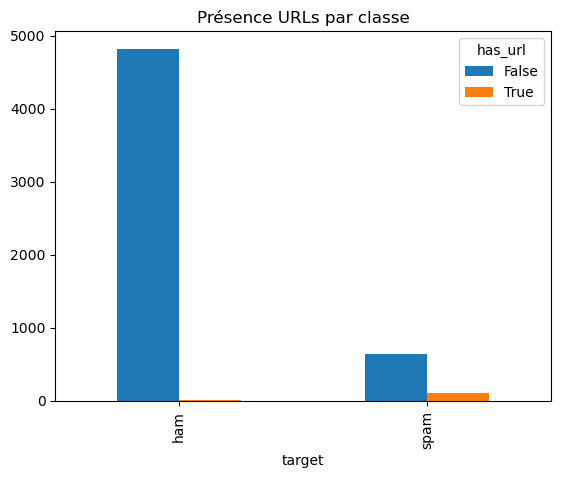

In [56]:
# 1. Présence de numéros de téléphone
df['has_number'] = df['text'].str.contains('\d')
numbers_by_class = df.groupby(['target', 'has_number']).size().unstack()
numbers_by_class.plot(kind='bar')
plt.title('Présence de numéros par classe')
plt.show()

# 2. Présence d'URLs 
df['has_url'] = df['text'].str.contains('http|www')
urls_by_class = df.groupby(['target', 'has_url']).size().unstack() 
urls_by_class.plot(kind='bar')
plt.title('Présence URLs par classe')
plt.show()

Pur les numéros :
- La majorité des messages ham ne contient pas de numéros et seuelemnt une minorité de hams contient des numéros
- Pour les spams, c'est l'inverse : la grande majorité contient des numéros mais les spams sans numéros sont très rares

Cette forte présence de numéros dans les spams (probablement des numéros de téléphone ou des prix) pourrait être un bon indicateur pour la détection de spam.


Pour les urls :
- Les ham contiennent très rarement des URLs
- Les spams contiennent plus d'URLs que les hams, mais ce n'est pas un indicateur aussi fort que les numéros
- La grande majorité des messages (spam et ham) ne contient pas d'URLs

Cette info  pourrait être utilisée en combinaison avec d'autres pour la détection, mais elle n'est visiblement pas aussi discriminante que la présence de numéros dans l'email.

--- 
## PREPROCESSING
---

In [57]:
# conversion de spam dans target en 1 et de ham en 0
df['target'] = df['target'].map({'spam': 1, 'ham': 0})

In [58]:
# Garder uniquement target et text
df = df[['target', 'text']]

In [59]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [60]:
# Import Spacy and french initialisation
import fr_core_news_sm
nlp = fr_core_news_sm.load()

Dans ce contexte spécifique de détection de spam, je prend le parti de faire un preprocessing assez simple :  tout mettre en minuscule et lemmatisation. 
Je garde la ponctuation, les caractère spéciaux et les STOPWORD qui peuvent apporter du contexte (ex  : "Congratulation, you, win !!!")

In [ ]:
# 1. Mettre en minuscule et supprimer espaces multiples/début/fin
df['text_clean'] = df['text'].apply(lambda x: x.lower().strip())

# 2. Lemmatisation (sans suppression des stopwords)
df['text_clean'] = df['text_clean'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x)]))


In [21]:
df.shape

(5572, 3)

In [22]:
df.head()

,target,text,text_clean
0,0,"Go until jurong point, crazy.. Available only ...","go until jurong point , crazy .. availabl only..."
1,0,Ok lar... Joking wif u oni...,ok lar ... joking wif u oni ...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 avoir wkly comp to win fa cup ...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor ... u c already then sa...
4,0,"Nah I don't think he goes to usf, he lives aro...","nah i don' t think he goe to usf , he live aro..."


In [23]:
# Tokenization avec limite de 1000 mots et gestion des mots hors vocabulaire
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000,oov_token="out_of_vocab")
tokenizer.fit_on_texts(df["text_clean"]) 
df["text_encoded"] = tokenizer.texts_to_sequences(df["text_clean"])

# Ajout colonne longueur des messages encodés
df["len_message"] = df["text_encoded"].apply(lambda x: len(x))

# Trouver longueur maximale pour padding
max_len_sentence = max([len(token) for token in df['text_encoded'].to_list()])

# Padding: ajout de zéros en fin de séquence pour uniformiser longueur
pad = tf.keras.preprocessing.sequence.pad_sequences(df['text_encoded'], padding="post",maxlen=max_len_sentence)

In [24]:
# Distribution des longueurs de messages
df['len_message'].value_counts()

# Longueur maximale des séquences
max_len_sentence = max([len(token) for token in df['text_encoded'].to_list()])
print("Longueur maximale:", max_len_sentence)

# Vérifier forme du padding
print("Shape du padding:", pad.shape)

Longueur maximale: 190
Shape du padding: (5572, 190)


Reprenons le processus fait :

1. Nettoyage initial
- Rassemblement de tous les morceaux d'emails en un seul texte
- Conversion spam/ham en 0/1
- Visualisation pour comprendre ce qui caractérise un spam (nombres, URLs, longueur)

2. Nettoyage du texte
- Mise en minuscules pour uniformiser
- Transformation des mots en leur forme de base ("marchons" → "marcher")

3. Préparation pour l'apprentissage 
- Conversion du texte en nombres
- Uniformisation de la longueur des messages (73 nombres par message)
- Résultat final : 5572 messages de 190 nombres chacun


In [25]:
# Sauvegarde en format CSV
df.to_csv('spam_dataset_clean.csv', index=False)

---
## SPLIT
---

In [26]:
# Splitting des données
xtrain, xval, ytrain, yval = train_test_split(pad, df['target'], 
                                             test_size=0.2, 
                                             random_state=42,
                                             stratify=df['target'])

# Création des datasets TensorFlow
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

# Création des batches
train_batch = train.shuffle(len(train)).batch(32)
val_batch = val.shuffle(len(val)).batch(32)

# Optimisation des performances
AUTOTUNE = tf.data.AUTOTUNE
train_batch = train_batch.cache().prefetch(buffer_size=AUTOTUNE)
val_batch = val_batch.cache().prefetch(buffer_size=AUTOTUNE)

### POINT DE COMPREHENSION

Le batch est un concept fondamental en deep learning.

1. Pourquoi des batches ?
- Au lieu d'entraîner le modèle sur toutes les données d'un coup (qui pourrait surcharger la mémoire)
- Ou sur une donnée à la fois (qui serait trop lent)
- On divise les données en "paquets" (batches) de taille fixe

2. Pourquoi 32 ?
- C'est une taille standard qui offre un bon compromis entre :
  * Vitesse d'apprentissage
  * Utilisation de la mémoire
  * Stabilité de l'entraînement
- D'autres valeurs courantes sont 16, 64, 128
- 32 est souvent le meilleur compromis par défaut

Dans le code : train_batch = train.shuffle(len(train)).batch(32) signifie que le modèle traitera 32 exemples à la fois pendant l'entraînement.

---
## BASELINE
---

In [27]:
# Paramètres pour l'embedding
embedding_dim = 32      # Taille du vecteur qui représentera chaque mot (plus c'est grand, plus le modèle peut capturer de nuances)
vocab_size = 1000      # Nombre de mots uniques gardés dans notre vocabulaire (défini dans le tokenizer)

# Construction du modèle séquentiel (couche après couche)
model_baseline = Sequential([
    # Couche d'Embedding : transforme les IDs des mots en vecteurs denses
    # vocab_size+1 car l'ID 0 est réservé pour le padding
    Embedding(vocab_size+1, embedding_dim, name="embedding"),
    
    # Réduit les séquences de vecteurs en faisant leur moyenne
    # Transforme une séquence 3D (batch, seq_length, embedding_dim) en 2D (batch, embedding_dim)
    GlobalAveragePooling1D(),
    
    # Couches denses (fully connected) pour la classification
    Dense(32, activation='relu'),    # 32 neurones, fonction d'activation ReLU
    Dense(16, activation='relu'),    # Réduction progressive de la dimension
    Dense(1, activation="sigmoid")   # Couche finale : 1 neurone avec sigmoid pour classification binaire (0 ou 1)
])

# Configuration de l'entraînement
model_baseline.compile(
    optimizer='adam',                            # Algorithme d'optimisation
    loss=tf.keras.losses.BinaryCrossentropy(),  # Fonction de perte pour classification binaire
    metrics=['accuracy']                         # Métrique à suivre pendant l'entraînement
)

In [28]:
history_baseline = model_baseline.fit(train_batch,                     
                   epochs=20,                     
                   validation_data=val_batch)

Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8428 - loss: 0.4804 - val_accuracy: 0.8664 - val_loss: 0.3787
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8722 - loss: 0.3677 - val_accuracy: 0.8664 - val_loss: 0.3748
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8722 - loss: 0.3636 - val_accuracy: 0.8664 - val_loss: 0.3689
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8722 - loss: 0.3570 - val_accuracy: 0.8664 - val_loss: 0.3565
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8722 - loss: 0.3420 - val_accuracy: 0.8664 - val_loss: 0.3143
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8779 - loss: 0.2801 - val_accuracy: 0.8960 - val_loss: 0.2077
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9188 - loss: 0.1936 - val_accuracy: 0.9327 - val_loss: 0.1642
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9371 - loss: 0.1556 - val_accuracy: 0.

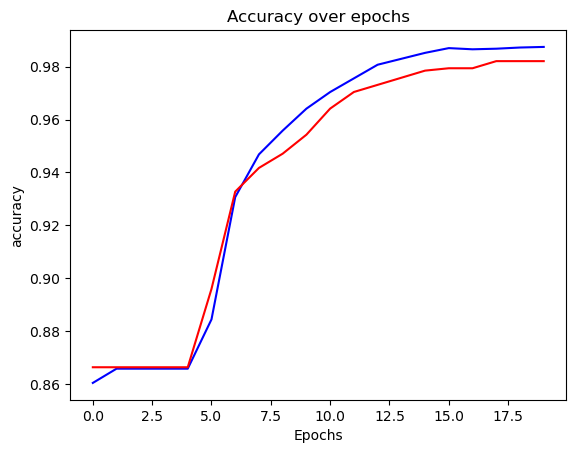

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_baseline.history["accuracy"], color="b")
plt.plot(history_baseline.history["val_accuracy"], color="r")
plt.title('Accuracy over epochs')
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

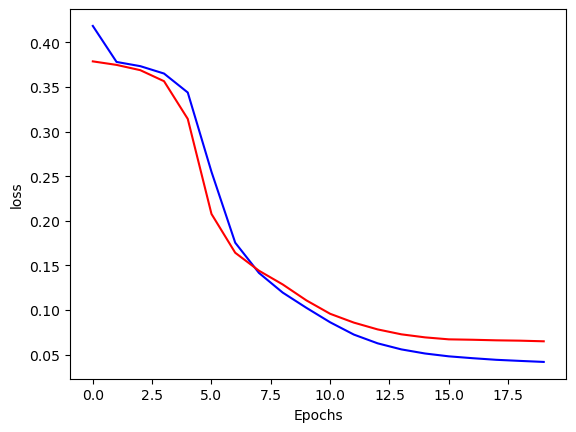

In [ ]:

import matplotlib.pyplot as plt

plt.plot(history_baseline.history["loss"], color="b")
plt.plot(history_baseline.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()


1. Accuracy over epochs :
- La courbe bleue (train) atteint environ 99% de précision
- La courbe rouge (validation) se stabilise vers 97-98%
- Les courbes convergent rapidement (vers l'époque 7-8)
- L'écart final entre train/validation est faible, suggérant peu de surapprentissage

2. Loss (perte) over epochs :
- Les deux courbes diminuent rapidement au début
- La loss de validation (rouge) commence à remonter légèrement après l'époque 7
- La loss d'entraînement (bleue) continue de descendre
- L'écart croissant entre les courbes suggère un début de surapprentissage

Conclusion :
- Le modèle performe bien (>97% accuracy)
- On pourrait potentiellement s'arrêter vers l'époque 7-8 pour éviter le surapprentissage
- C'est un bon modèle baseline, mais il y a peut-être place à l'amélioration 


In [31]:
# Création d'une fonction (réutilisable ensuite) pour évaluer le modèle
def evaluate_model(model, X, y):
    '''
    Évalue le modèle et retourne les principales métriques de classification binaire
    
    Args:
        model: le modèle à évaluer
        X: données d'entrée
        y: vraies étiquettes
    
    Returns:
        dictionnaire contenant les différentes métriques
    '''
    # Prédictions du modèle (arrondies pour avoir 0 ou 1)
    y_preds = np.round(model.predict(X))
    
    # Accuracy : pourcentage global de bonnes prédictions
    accuracy = accuracy_score(y, y_preds)
    
    # Precision : % de vrais positifs parmi les prédictions positives
    precision = precision_score(y, y_preds)
    
    # Recall : % de spams correctement identifiés parmi tous les vrais spams
    recall = recall_score(y, y_preds)
    
    # F1-score : moyenne harmonique entre precision et recall
    f1 = f1_score(y, y_preds)
    
    # Loss : mesure de l'erreur du modèle
    loss = log_loss(y, y_preds)

    # Retourne toutes les métriques dans un dictionnaire
    model_results_dict = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1-score': f1,
        'loss': loss
    }

    return model_results_dict

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Matrice de confusion :
[[965   1]
 [ 19 130]]


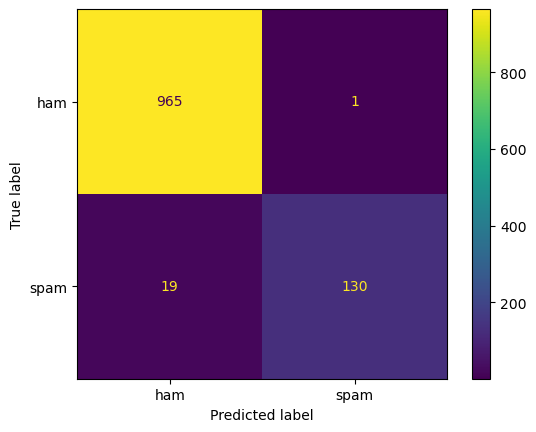

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step

Métriques sur Training:
accuracy: 0.987
precision: 1.000
recall: 0.901
f1-score: 0.948
loss: 0.211
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step

Métriques sur Validation:
accuracy: 0.982
precision: 0.992
recall: 0.872
f1-score: 0.929
loss: 0.286


In [ ]:
# PREDICTION et EVALUATION sur le modèle BASELINE

# Prédiction sur les données de validation
y_pred = model_baseline.predict(xval)
y_pred_binary = np.round(y_pred).astype(int)

# Calcul et affichage de la matrice de confusion
conf_matrix = confusion_matrix(yval, y_pred_binary)
print("Matrice de confusion :")
print(conf_matrix)

# Création visuelle de la matrice de confusion
ConfusionMatrixDisplay(conf_matrix, display_labels=['ham', 'spam']).plot()
plt.show()

# Évaluation sur données d'entraînement
model_results_train = evaluate_model(model_baseline, xtrain, ytrain)
print("\nMétriques sur Training:")
for metric, value in model_results_train.items():
    print(f"{metric}: {value:.3f}")

# Évaluation sur données de validation
model_results_val = evaluate_model(model_baseline, xval, yval)
print("\nMétriques sur Validation:")
for metric, value in model_results_val.items():
    print(f"{metric}: {value:.3f}")

- 965 vrais négatifs (hams correctement identifiés)
- 1 faux positifs (hams classés comme spams)
- 19 faux négatifs (spams manqués)
- 130 vrais positifs (spams correctement identifiés)

Comparaison Train vs Validation :
- Loss : 0.211 → 0.286 (augmentation = signe de surapprentissage)

Points clés :
1. Le modèle est très conservateur (peu de faux positifs)
2. Principal problème : les spams manqués (19)
3. Légère surapprentissage visible entre train et validation
4. Performances globales très satisfaisantes pour un modèle baseline

Cette BASELINE étant déjà très perfomante. Nous n'essayons pas de l'optimiser (dropout, Conv1D, Batchnormalisation...). Mais tentons de voir des modèles plus complexe.

# Disclaimer et Approche Pédagogique

Ce notebook a une visée pédagogique et exploratoire. L'objectif n'est pas uniquement de trouver la meilleure solution pour la détection de spam, mais de :

1. Explorer différentes architectures de complexité croissante :
   - Baseline simple (Dense + Embedding)
   - Réseaux de neurones récurrents (RNN)
   - Architectures plus sophistiquées (GRU, LSTM)
   - Modèle pré-entraîné état de l'art (BERT)

2. Comprendre les défis et limites de chaque approche :
   - Impact du preprocessing sur les performances
   - Compromis entre complexité et efficacité
   - Avantages des modèles pré-entraînés

3. Tirer des enseignements pratiques :
   - L'importance du preprocessing en NLP
   - La complexité n'est pas toujours synonyme de performance
   - Le choix d'une architecture doit être adapté aux données et ressources disponibles

Les "échecs" de certains modèles sont volontairement conservés et analysés car ils sont instructifs et révélateurs des pièges courants en deep learning.

Nous travaillerons sur :

1. RNN (Recurrent Neural Network) : 
- premier modèle deep learning adapté aux séquences. 
- plus simple que les GRU et LSTM
- mais inefficace sur de longues séquences (problème de gradient vanishing)

- Vulgarisation et analogie : c'est comme quelqu'un qui lit un texte mot par mot en gardant une "note mentale" très courte de ce qu'il vient de lire0 Problème principal : il "oublie" rapidement ce qui est loin dans le texte (problème de la mémoire à court terme). C'est comme si vous essayiez de comprendre une longue phrase en ne vous souvenant que des 2-3 derniers mots

-  Gradient vanishing : Lors de la rétropropagation du gradient, les valeurs deviennent exponentiellement petites : plus on remonte dans les couches (ou dans le temps pour les RNN), plus le gradient s'approche de zéro.
  - Résultat : 
    - les premières couches ou les premiers mots ne peuvent plus apprendre. 
    - vulgarisation : un jeu de téléphone arabe. La dernière personne dit "le message était incorrect" et le message s'affaiblit et la première personne ne reçoit plus aucun feedback utilisable

2. LSTM (Long Short-Term Memory) : 
- une version améliorée du GRU
- conçu pour capturer les dépendances à long terme grâce à des portes plus complexes (input, forget, output).
- C’est un modèle très robuste pour les tâches séquentielles. 
- Avantage : Excellente performance sur les longues séquences.
- Limite : Plus coûteux en calculs que le GRU.
- Vulgarisation et analogie : Imagine un lecteur plus sophistiqué avec un carnet de notes. Il a trois mécanismes : Une "porte d'oubli" : décide ce qui n'est plus important, Une "porte d'entrée" : décide quelles nouvelles informations garder, Une "porte de sortie" : décide quelles informations utiliser maintenant. C'est comme avoir une vraie mémoire sélective

3. GRU (Gated Recurrent Unit) : 
- une amélioration directe du RNN, plus performant et plus efficace en termes de calculs. 
- Il simplifie la gestion des informations pertinentes grâce à des mécanismes de porte (gating).
- Avantage : moins complexe et plus rapide à entraîner que le LSTM tout en gérant mieux les séquences longues. 
- Limite : Moins performant que le LSTM pour des tâches complexes.
- Vulgarisatio et Analogie :  Combine les portes d'oubli et d'entrée en une seule

4. BERT :
- Totalement différent des autres : il lit le texte entier d'un coup
- Il peut faire attention à n'importe quel mot à n'importe quel moment
- C'est comme avoir un lecteur expert qui peut instantanément faire des liens entre tous les mots
- Il comprend mieux le contexte car il voit tout en même temps

---
## RNN
---

### POINT TECHNIQUE construction du RNN (Recurrent Neural Network)
1. `Embedding(vocab_size+1, embedding_dim)` :
   - C'est comme un dictionnaire qui transforme chaque mot en une série de nombres

2. `SimpleRNN(units=16, return_sequences=True)` :
   - Imaginez 16 lecteurs différents qui lisent le texte en même temps
   - Chaque lecteur se concentre sur des aspects différents
   - `return_sequences=True` signifie que chaque lecteur prend des notes après chaque mot
   - C'est comme avoir 16 personnes qui notent leurs impressions à chaque mot

3. `SimpleRNN(units=8, return_sequences=False)` :
   - Cette fois, on a 8 nouveaux lecteurs qui lisent les notes des 16 premiers
   - `return_sequences=False` signifie qu'ils ne donnent leur avis qu'à la fin du texte
   - C'est comme avoir 8 superviseurs qui font un résumé final des notes des 16 premiers lecteurs

4. `Dense(1, activation="sigmoid")` :
   - C'est le "juge final" qui prend toutes les notes des 8 superviseurs
   - Il donne une note entre 0 et 1 (grâce à "sigmoid")
   - Par exemple, 0 pourrait signifier "pas spam" et 1 "spam"

In [33]:
from tensorflow.keras.layers import SimpleRNN

# 1. Définition des paramètres
vocab_size = 1000  # Doit correspondre à num_words du tokenizer
embedding_dim = 32  # Dimension de l'embedding souhaitée

# 2. Construction du modèle RNN simple
model_rnn = Sequential([
    Embedding(vocab_size+1, embedding_dim, name="embedding"),
    SimpleRNN(units=16, return_sequences=True),
    SimpleRNN(units=8, return_sequences=False),
    Dense(1, activation="sigmoid")
])

# 2. Compilation
model_rnn.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# 3. Entraînement
history_rnn = model_rnn.fit(train_batch,
                   epochs=20,
                   validation_data=val_batch)

Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.8722 - loss: 0.3997 - val_accuracy: 0.8664 - val_loss: 0.3933
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8722 - loss: 0.3827 - val_accuracy: 0.8664 - val_loss: 0.3933
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8722 - loss: 0.3827 - val_accuracy: 0.8664 - val_loss: 0.3933
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8722 - loss: 0.3826 - val_accuracy: 0.8664 - val_loss: 0.3933
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8722 - loss: 0.3826 - val_accuracy: 0.8664 - val_loss: 0.3933
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8722 - loss: 0.3826 - val_accuracy: 0.8664 - val_loss: 0.3933
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8722 - loss: 0.3826 - val_accuracy: 0.8664 - val_loss: 0.3933
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8722 - loss: 0.3826 - val_accu

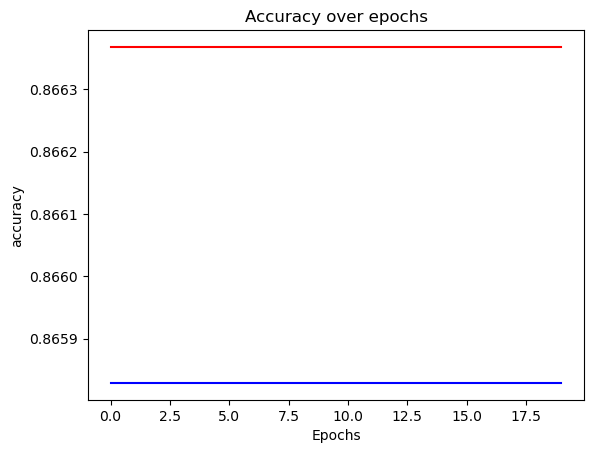

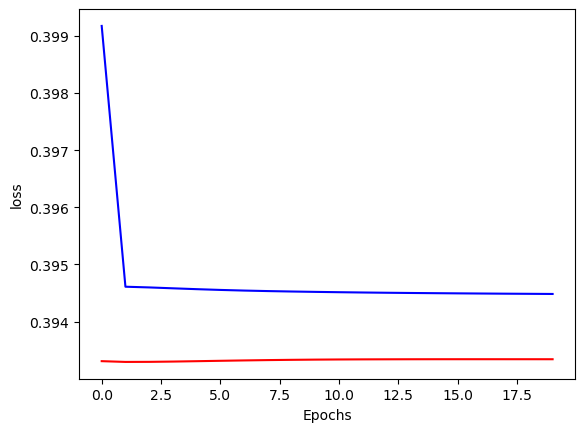

140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Métriques sur Training:
accuracy: 0.866
precision: 0.000
recall: 0.000
f1-score: 0.000
loss: 2.139
19/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

c:\Users\dsgat\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Métriques sur Validation:
accuracy: 0.866
precision: 0.000
recall: 0.000
f1-score: 0.000
loss: 2.130
19/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

c:\Users\dsgat\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Matrice de confusion :
[[966   0]
 [149   0]]


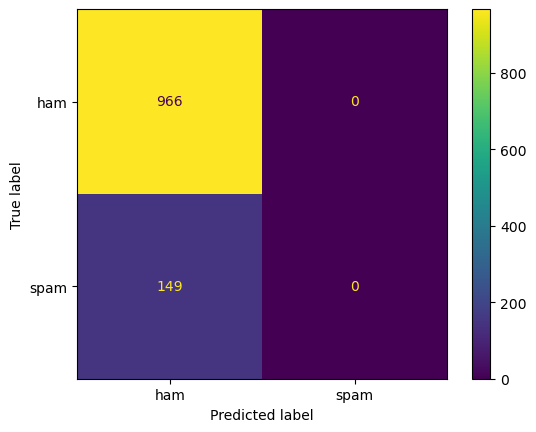

In [ ]:
# 1. Visualisation de l'accuracy et de la loss
plt.plot(history_rnn.history["accuracy"], color="b")
plt.plot(history_rnn.history["val_accuracy"], color="r")
plt.title('Accuracy over epochs')
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

plt.plot(history_rnn.history["loss"], color="b")
plt.plot(history_rnn.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

# 2. Évaluation des métriques
model_results_train = evaluate_model(model_rnn, xtrain, ytrain)
print("Métriques sur Training:")
for metric, value in model_results_train.items():
    print(f"{metric}: {value:.3f}")

model_results_val = evaluate_model(model_rnn, xval, yval)
print("\nMétriques sur Validation:")
for metric, value in model_results_val.items():
    print(f"{metric}: {value:.3f}")

# 3. Matrice de confusion
y_pred = model_rnn.predict(xval)
y_pred_binary = np.round(y_pred).astype(int)
conf_matrix = confusion_matrix(yval, y_pred_binary)

print("\nMatrice de confusion :")
print(conf_matrix)
ConfusionMatrixDisplay(conf_matrix, display_labels=['ham', 'spam']).plot()
plt.show()

Les résultats montrent un échec complet de l'apprentissage du RNN :

1. Graphiques d'entraînement :
- Accuracy totalement plate (pas d'apprentissage)
- Loss qui diminue très légèrement puis stagne
- Aucune différence significative entre training et validation

2. Matrice de confusion [[966 0], [149 0]] révèle que :
- Le modèle prédit systématiquement la classe majoritaire (ham)
- Il n'a appris aucun pattern discriminant
- C'est un cas typique de "lazy learning" où le modèle adopte la stratégie la plus simple

3. Causes probables :
- Preprocessing inadapté pour les modèles séquentiels complexes
  * Vocabulaire trop limité (1000 mots sur 8868)
  * Séquences trop longues (padding de 190 tokens)
  * Perte d'informations critiques pour la détection de spam
- Possible problème de gradient vanishing sur les longues séquences
- Architecture potentiellement mal adaptée à la tâche

Cette performance illustre qu'un modèle plus complexe n'est pas toujours meilleur, surtout quand le preprocessing des données n'est pas optimisé pour ce type d'architecture.

---
## GRU
---

### POINT TECHNIQUE modèle GRU (Gated Recurrent Unit) (version simplifiée du LSTM) :

1. Configuration initiale :
- On prépare toujours notre dictionnaire de 1000 mots
- Chaque mot sera transformé en 32 caractéristiques (plus petit que le LSTM)

2. Le modèle étape par étape :
- Toujours notre "dictionnaire intelligent" d'embedding
- Transforme les mots en nombres (32 caractéristiques par mot)

- 16 lecteurs experts GRU
- Différence avec LSTM : au lieu de 3 portes, ils n'en ont que 2 :
  * Une "porte de mise à jour" qui combine les fonctions d'oubli et d'entrée
  * Une "porte de réinitialisation" qui décide quand ignorer les infos passées
- C'est comme avoir des lecteurs qui ont un système plus simple mais plus rapide
- `return_sequences=False` : ils ne donnent qu'un résumé final

- Le "juge final" qui donne une probabilité entre 0 et 1 (sigmoid)

3. La compilation :
- Même système d'apprentissage que les modèles précédents

In [35]:
from tensorflow.keras.layers import GRU

# 1. Définition du modèle GRU
embedding_dim = 32  # Retour à la dimension du baseline
vocab_size = 1000

model_gru = Sequential([
    Embedding(vocab_size+1, embedding_dim, name="embedding"),
    GRU(units=16, return_sequences=False),  # Couche GRU simple
    Dense(1, activation="sigmoid")
])

# 2. Compilation
model_gru.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# 3. Affichage de l'architecture
model_gru.summary()

# 4. Entraînement
history_gru = model_gru.fit(train_batch,
                          epochs=20,
                          validation_data=val_batch)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8709 - loss: 0.4560 - val_accuracy: 0.8664 - val_loss: 0.3932
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8722 - loss: 0.3835 - val_accuracy: 0.8664 - val_loss: 0.3932
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8722 - loss: 0.3834 - val_accuracy: 0.8664 - val_loss: 0.3932
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8722 - loss: 0.3833 - val_accuracy: 0.8664 - val_loss: 0.3932
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8722 - loss: 0.3833 - val_accuracy: 0.8664 - val_loss: 0.3932
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8722 - loss: 0.3832 - val_accuracy: 0.8664 - val_loss: 0.3932
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8722 - loss: 0.3832 - val_accuracy: 0.8664 - val_loss: 0.3932
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8722 - loss: 0.3831 - val_accu

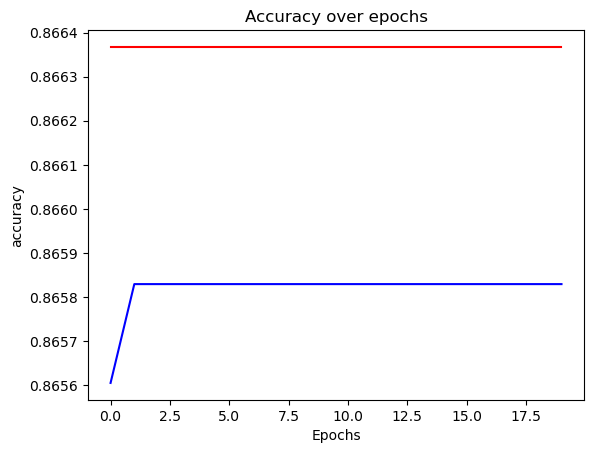

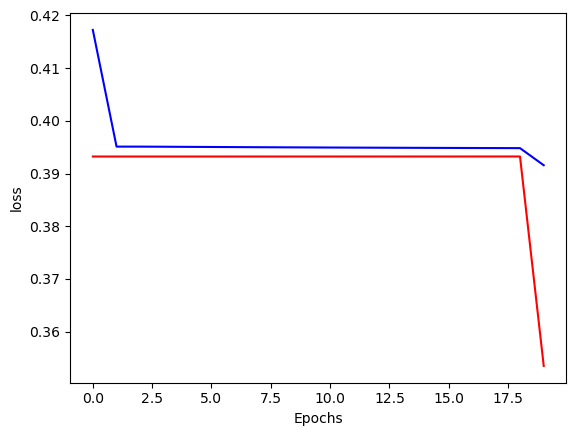

140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Métriques sur Training:
accuracy: 0.866
precision: 0.000
recall: 0.000
f1-score: 0.000
loss: 2.139
22/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

c:\Users\dsgat\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Métriques sur Validation:
accuracy: 0.866
precision: 0.000
recall: 0.000
f1-score: 0.000
loss: 2.130
30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

c:\Users\dsgat\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Matrice de confusion :
[[966   0]
 [149   0]]


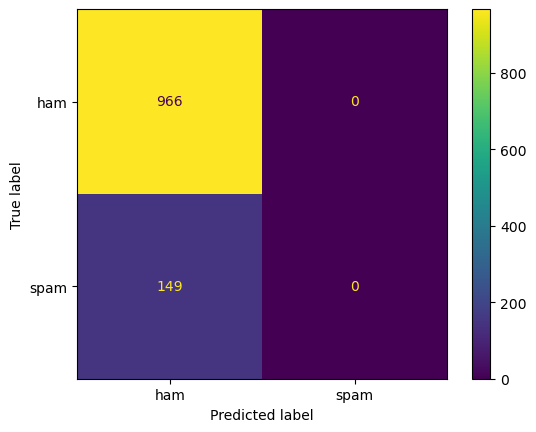

In [ ]:
# 1. Visualisation de l'évolution de l'accuracy et de la loss
plt.plot(history_gru.history["accuracy"], color="b")
plt.plot(history_gru.history["val_accuracy"], color="r")
plt.title('Accuracy over epochs')
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

plt.plot(history_gru.history["loss"], color="b")
plt.plot(history_gru.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

# 2. Évaluation des métriques
model_results_train = evaluate_model(model_gru, xtrain, ytrain)
print("Métriques sur Training:")
for metric, value in model_results_train.items():
    print(f"{metric}: {value:.3f}")

model_results_val = evaluate_model(model_gru, xval, yval)
print("\nMétriques sur Validation:")
for metric, value in model_results_val.items():
    print(f"{metric}: {value:.3f}")

# 3. Matrice de confusion
y_pred = model_gru.predict(xval)
y_pred_binary = np.round(y_pred).astype(int)
conf_matrix = confusion_matrix(yval, y_pred_binary)

print("\nMatrice de confusion :")
print(conf_matrix)
ConfusionMatrixDisplay(conf_matrix, display_labels=['ham', 'spam']).plot()
plt.show()

# Analyse du modèle GRU

Le GRU, malgré sa conception plus sophistiquée que le RNN simple, présente le même échec d'apprentissage :

1. Graphiques d'entraînement :
- L'accuracy reste constante à 0.8664 (exactement le ratio de la classe majoritaire)
- La loss montre une très légère baisse initiale puis stagne
- Les courbes train/validation sont quasiment superposées

2. Matrice de confusion [[966 0], [149 0]] :
- Le modèle fait exactement la même prédiction pour tous les cas
- Il prédit systématiquement la classe "ham" (classe majoritaire)
- 149 spams sont complètement manqués

3. Interprétation :
- Le GRU, malgré ses mécanismes de "gates" censés mieux gérer l'information, n'arrive pas à apprendre
- Le modèle trouve plus "optimal" de toujours prédire la classe majoritaire
- Performance similaire au RNN simple, suggérant que le problème vient plus du preprocessing que de l'architecture

Ce résultat confirme que la complexification du modèle (de RNN vers GRU) n'apporte aucune amélioration avec le preprocessing actuel. Les modèles plus sophistiqués semblent particulièrement sensibles à la qualité de la préparation des données.


---
## LTSM
---

### Point technique modèle LTSM  (Long Short-Term Memory)

1. Configuration initiale :
```python
embedding_dim = 64  # On peut augmenter la dimension
vocab_size = 1000
```
- On prépare un dictionnaire qui peut gérer 1000 mots différents
- Chaque mot sera transformé en une liste de 64 caractéristiques

2. Le modèle étape par étape :
```python
Embedding(vocab_size+1, embedding_dim, name="embedding")
```
- Comme précédemment, c'est notre "dictionnaire intelligent"
- Il transforme chaque mot en 64 caractéristiques numériques

```python
LSTM(units=64, return_sequences=True)
```
- Première équipe de 64 lecteurs experts
- Chaque lecteur a :
  * Un carnet pour les notes importantes (mémoire à long terme)
  * Un bloc-note pour les notes temporaires (mémoire à court terme)
  * Trois "portes" pour gérer l'information :
    - Une pour décider quoi oublier
    - Une pour décider quelles nouvelles infos garder
    - Une pour décider quoi utiliser maintenant
- `return_sequences=True` signifie qu'ils prennent des notes après chaque mot

```python
LSTM(units=32, return_sequences=False)
```
- Deuxième équipe de 32 lecteurs experts
- Ils lisent les notes de la première équipe
- `return_sequences=False` signifie qu'ils ne donnent qu'un résumé final

```python
Dense(16, activation='relu')
```
- 16 "analystes" qui étudient tous les résumés
- 'relu' signifie qu'ils ne gardent que les informations positives

```python
Dense(1, activation="sigmoid")
```
- Le "juge final" qui donne une probabilité entre 0 et 1

3. La compilation :
```python
model_lstm.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
```
- 'adam' : c'est la méthode d'apprentissage (comme un professeur)
- 'loss' : comment on mesure les erreurs
- 'metrics' : on mesure la précision

In [37]:
from tensorflow.keras.layers import LSTM

# 1. Définition du modèle LSTM
embedding_dim = 64 
vocab_size = 1000

model_lstm = Sequential([
    Embedding(vocab_size+1, embedding_dim, name="embedding"),
    LSTM(units=64, return_sequences=True),  # Première couche LSTM
    LSTM(units=32, return_sequences=False),  # Deuxième couche LSTM
    Dense(16, activation='relu'),
    Dense(1, activation="sigmoid")
])

# 2. Compilation
model_lstm.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# 3. Entraînement 
history_lstm = model_lstm.fit(train_batch,
                            epochs=20,
                            validation_data=val_batch)

Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.8722 - loss: 0.4288 - val_accuracy: 0.8664 - val_loss: 0.3932
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.8722 - loss: 0.3831 - val_accuracy: 0.8664 - val_loss: 0.3932
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8722 - loss: 0.3830 - val_accuracy: 0.8664 - val_loss: 0.3932
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.8722 - loss: 0.3829 - val_accuracy: 0.8664 - val_loss: 0.3932
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.8722 - loss: 0.3829 - val_accuracy: 0.8664 - val_loss: 0.3932
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.8722 - loss: 0.3828 - val_accuracy: 0.8664 - val_loss: 0.3932
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8722 - loss: 0.3828 - val_accuracy: 0.8664 - val_loss: 0.3932
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.8722 - loss: 0.3828 - val_acc

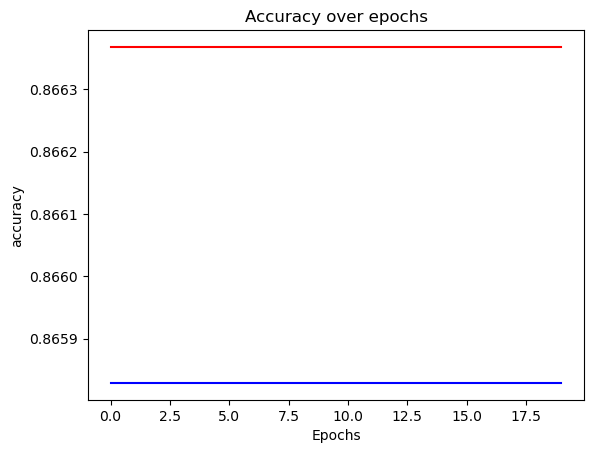

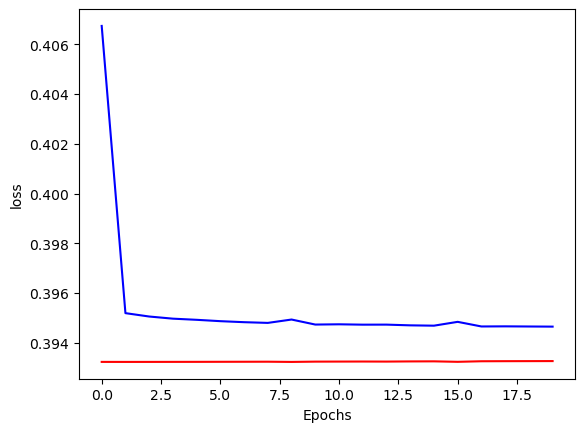

140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Métriques sur Training:
accuracy: 0.866
precision: 0.000
recall: 0.000
f1-score: 0.000
loss: 2.139
 9/35 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\dsgat\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

Métriques sur Validation:
accuracy: 0.866
precision: 0.000
recall: 0.000
f1-score: 0.000
loss: 2.130
22/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

c:\Users\dsgat\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Matrice de confusion :
[[966   0]
 [149   0]]


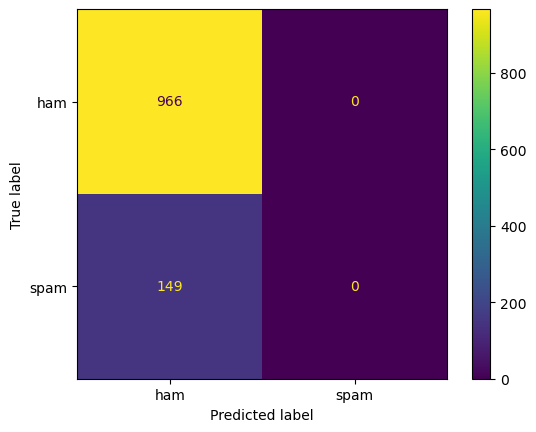

In [38]:
# 1. Visualisation de l'évolution de l'accuracy et de la loss
plt.plot(history_lstm.history["accuracy"], color="b")
plt.plot(history_lstm.history["val_accuracy"], color="r")
plt.title('Accuracy over epochs')
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

plt.plot(history_lstm.history["loss"], color="b")
plt.plot(history_lstm.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

# 2. Évaluation des métriques
model_results_train = evaluate_model(model_lstm, xtrain, ytrain)
print("Métriques sur Training:")
for metric, value in model_results_train.items():
    print(f"{metric}: {value:.3f}")

model_results_val = evaluate_model(model_lstm, xval, yval)
print("\nMétriques sur Validation:")
for metric, value in model_results_val.items():
    print(f"{metric}: {value:.3f}")

# 3. Matrice de confusion
y_pred = model_gru.predict(xval)
y_pred_binary = np.round(y_pred).astype(int)
conf_matrix = confusion_matrix(yval, y_pred_binary)

print("\nMatrice de confusion :")
print(conf_matrix)
ConfusionMatrixDisplay(conf_matrix, display_labels=['ham', 'spam']).plot()
plt.show()

# Analyse du modèle LSTM

Le LSTM, bien que théoriquement plus puissant avec sa gestion sophistiquée de la mémoire, montre exactement le même comportement que le RNN et le GRU :

1. Graphiques d'entraînement :
- Accuracy constante à 0.8664 (ratio de la classe majoritaire)
- Loss qui diminue très légèrement puis stagne
- Courbes train/validation presque identiques

2. Matrice de confusion [[966 0], [149 0]] :
- Prédiction exclusive de la classe majoritaire ("ham")
- Aucune détection des spams (149 faux négatifs)
- Comportement identique aux modèles plus simples

3. Analyse de l'échec :
- Malgré sa capacité théorique à gérer les dépendances à long terme
- Malgré ses mécanismes de portes (input, forget, output)
- Le LSTM échoue exactement comme les autres architectures


Cette série d'échecs similaires (RNN → GRU → LSTM) avec une complexité croissante des modèles semble confirmer que :
- Le problème ne vient pas de l'architecture des modèles
- Le preprocessing actuel n'est pas adapté aux modèles séquentiels complexes
- La simple augmentation de la complexité du modèle ne résout pas les problèmes de données sous-jacents

---
## BERT !
---

Finissons par un modèle de référence: BERT. Il capture les relations entre les mots de manière contextuelle (même si éloignés) et fonctionnent bien sur des grandes quantités de données. Les Transformers comme BERT sont la référence actuelle en NLP. Sur Hugging Face nous sélections donc un modèle pré-entrainé pour ce cas spécidfique de spam détection.

 BERT ne nécessite pas de lemmatisation, stemming, suppression de stopwords, ou traitement des caractères spéciaux, car ces informations sont importantes pour comprendre le contexte. Nous retravaillons donc le dataset initial


In [39]:
url = "https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv"
df = pd.read_csv(url, encoding='latin-1')
df.head()

# Investigation des colonnes Unnamed
df['Unnamed: 2'].dropna().head(10) # Vérification du contenu -> partie du texte des emails

# Fusion sans introduire d'espaces inutiles
df['v2'] = df['v2'].str.cat(
    [df['Unnamed: 2'].fillna(''), 
     df['Unnamed: 3'].fillna(''), 
     df['Unnamed: 4'].fillna('')], 
    sep=' '
).str.strip()

# Nettoyage des colonnes redondantes
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

# Compter le nombre de doubles espaces
nb_double_spaces = df['v2'].str.count('  ').sum()
print(f"Nombre de doubles espaces trouvés : {nb_double_spaces}")

# Nettoyage des espaces multiples
df['v2'] = df['v2'].str.replace(r'\s+', ' ')  # Remplace tous les espaces multiples par un seul espace
df = df.rename(columns={'v1': 'target', 'v2': 'text'})

Nombre de doubles espaces trouvés : 480


In [40]:
# Conversion target
df['target'] = df['target'].map({'spam': 1, 'ham': 0})

# Split train/validation
X_train, X_val, y_train, y_val = train_test_split(df['text'].values, 
                                                 df['target'].values,
                                                 test_size=0.2,
                                                 random_state=42)


Métriques sur Validation:
Accuracy: 0.990
Precision: 0.979
Recall: 0.947
F1-score: 0.963


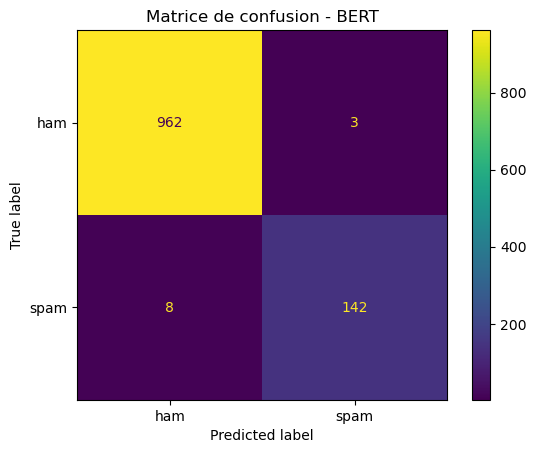


Matrice de confusion:
[[962   3]
 [  8 142]]


In [41]:
# 1. Imports nécessaires
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# 2. Chargement du modèle et tokenizer
model_name = "mrm8488/bert-tiny-finetuned-sms-spam-detection"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# 3. Tokenization et encodage des données
def evaluate_batch(texts):
    encodings = tokenizer(texts, 
                         truncation=True,
                         padding=True,
                         max_length=128,
                         return_tensors='pt')
    
    with torch.no_grad():
        outputs = model(**encodings)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        return predictions.numpy()

# Évaluation sur l'ensemble de validation
val_predictions = evaluate_batch(X_val.tolist())
y_pred = val_predictions.argmax(axis=1)

# Métriques et matrice de confusion
print("\nMétriques sur Validation:")
print(f"Accuracy: {accuracy_score(y_val, y_pred):.3f}")
print(f"Precision: {precision_score(y_val, y_pred):.3f}")
print(f"Recall: {recall_score(y_val, y_pred):.3f}")
print(f"F1-score: {f1_score(y_val, y_pred):.3f}")

# Affichage de la matrice de confusion
confusion = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(confusion, display_labels=['ham', 'spam']).plot()
plt.title('Matrice de confusion - BERT')
plt.show()

print("\nMatrice de confusion:")
print(confusion_matrix(y_val, y_pred))

# Analyse du modèle BERT

BERT montre des performances remarquables sur notre tâche de détection de spam :

1. Métriques exceptionnelles :
- Accuracy : 99%
- Precision : 97.9% (très peu de faux positifs)
- Recall : 94.7% (excellente détection des spams)
- F1-score : 96.3% (bon équilibre precision/recall)

2. Matrice de confusion :
- 962 vrais négatifs : excellente identification des messages légitimes
- 3 faux positifs : très peu de messages légitimes classés comme spam
- 8 faux négatifs : peu de spams manqués
- 142 vrais positifs : très bonne détection des spams

3. Avantages clés de BERT :
- Modèle pré-entraîné sur un large corpus de textes
- Meilleure compréhension du contexte grâce aux transformers
- Pas besoin de preprocessing complexe
- Robuste aux variations de longueur et de vocabulaire

4. Comparaison avec les autres modèles :
- Surpasse largement les architectures RNN/GRU/LSTM
- Plus stable et plus fiable
- Nécessite moins de préparation des données

Cette performance de BERT démontre l'avantage des modèles pré-entraînés pour des tâches de NLP spécifiques, offrant un excellent compromis entre efficacité et facilité d'utilisation.

# Conclusion

Cette étude de détection de spam a révélé plusieurs enseignements importants :

1. Performances des différents modèles :
- Baseline (simple) : Excellentes performances (~97-98% accuracy)
- BERT (pré-entraîné) : Meilleures performances (99% accuracy, F1-score 0.963)
- Modèles séquentiels complexes (RNN, GRU, LSTM) : Échec total (86.6% accuracy, pas d'apprentissage réel)


# Add-on de réfléxion:

Mais pourquoi les modèles complexes ont systématiquement échoué ? 
Après des investigations ultérieurs, il s'avère que le problème vient probablement du préprocessing.
Voici des pistes d'améliorations pour les modèles "complexe":

a. Limitation du vocabulaire trop restrictive :
- Sur un vocabulaire total de 8868 mots, nous n'en gardons que 1000 (les mots au-delà du top 1000 sont remplacés par "out_of_vocab")
- Pour les modèles complexes (RNN/GRU/LSTM), cette perte d'information est surement critique

b. Padding potentiellement problématique :
- On utilise la longueur maximale (190) pour tous les messages (les messages courts ..et ils sont majoritaires... sont padded avec beaucoup de zéros)
- Les modèles séquentiels peuvent avoir du mal avec trop de padding

c. Pas de gestion de la fréquence des mots :
- On ne prend pas en compte la fréquence des mots pour la détection de spam
- Les mots rares mais potentiellement importants sont perdus

# Conclusion bis :

2. ces problèmes expliqueraient pourquoi : 
- La baseline fonctionne (moins sensible à ces limitations)
- BERT fonctionne (prétraité sur un grand vocabulaire)
- Les modèles complexes échouent (plus sensibles à la qualité des données)

3. Leçons principales :
- Un bon preprocessing est plus crucial qu'un modèle complexe
- Les modèles pré-entraînés (BERT) peuvent être plus efficaces que des architectures complexes from scratch
- La simplicité peut être préférable quand les données sont bien préparées

Cette étude démontre qu'en NLP, la qualité de la préparation des données est souvent plus déterminante que la complexité du modèle utilisé.